In [1]:
import sys
print(sys.executable)

/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/bin/python


In [2]:
# !/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/bin/python -m pip install pandas 
# !/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/bin/python -m pip install seaborn
# !/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/bin/python -m pip install tabulate
# !/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/bin/python -m pip install scikit-learn
# !/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/bin/python -m pip install imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from xgboost.sklearn import XGBClassifier

In [4]:
def visual(data, column_name):
    facet = sns.FacetGrid(data, hue='Survived', aspect=5)
    facet.map(sns.kdeplot, column_name, fill=True)
    facet.set(xlim=(0, data[column_name].max()))
    plt.xlim(0)
    plt.legend()

In [5]:
train_df = pd.read_csv('data/titanic/train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### Visualization
Note that **Kernel Density Estimation (KDE)** is a way to estimate the probability density function of a continuous random variable.

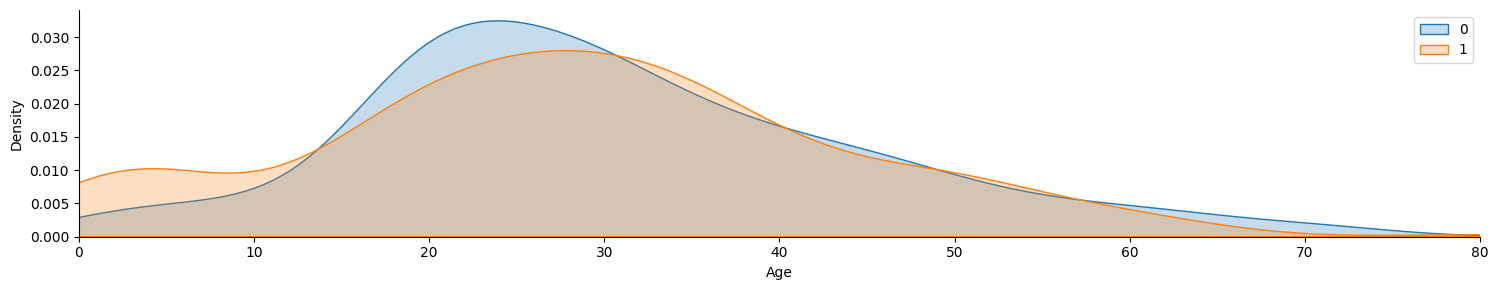

In [9]:
visual(train_df, column_name='Age')

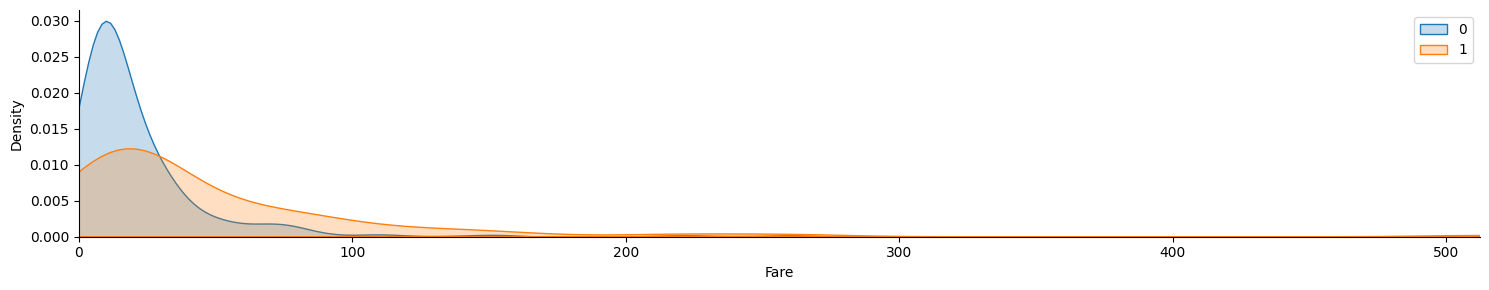

In [10]:
visual(train_df, column_name='Fare')

In [11]:
class Preprocess:
    def __init__(self):
        self.data = None
        self.sc = None

    def _cabin_to_cat(self):
        data = self.data
        data['Cabin'] = data['Cabin'].fillna(0)
        data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
        data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
        data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
        data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
        data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
        data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
        data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
        if any('T' in str(s) for s in data['Cabin']): 
            data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8
        else:
            pass
        data['Cabin'] = data['Cabin'].astype('int64')
        self.data = data

    def _age_to_cat(self):
        data = self.data
        data.loc[data['Age'].isnull(), 'Age'] = data['Age'].mean()
        mean_age = data["Age"].mean()
        std_age = data["Age"].std()
        # data.loc[data['Age'].isnull(), 'Age'] = round(np.random.randint(mean_age - std_age, mean_age + std_age), 2)
        data['Age'] = data['Age'].astype('int64')
        data.loc[data['Age'] <= 10, 'Age'] = 0
        data.loc[(data['Age'] > 10) & (data['Age'] <= 30), 'Age'] = 1
        data.loc[(data['Age'] > 30) & (data['Age'] <= 60), 'Age'] = 2
        data.loc[data['Age'] > 60, 'Age'] = 3
        self.data = data

    def _sex_to_cat(self):
        data = self.data
        gender = {'male': 0, 'female': 1}
        data['Sex'] = data['Sex'].map(gender)
        self.data = data

    def _embarked_to_cat(self):
        data = self.data
        embarked = {'S': 0, 'C': 1, 'Q': 2}
        data.loc[data['Embarked'].isnull(), 'Embarked'] = 'S'
        data['Embarked'] = data['Embarked'].map(embarked)
        self.data = data

    def _fare_to_cat(self):
        data = self.data
        data.loc[data['Fare'].isnull(), 'Fare'] = 0
        data.loc[data['Fare'] <= 17, 'Fare'] = 0
        data.loc[(data['Fare'] > 17) & (data['Fare'] <= 30), 'Fare'] = 1
        data.loc[(data['Fare'] > 30) & (data['Fare'] <= 100), 'Fare'] = 2
        data.loc[data['Fare'] > 100, 'Fare'] = 3
        self.data = data

    def _name_to_cat(self):
        data = self.data
        data['Title'] = data.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)
        data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
                                               'Sir', 'Jonkheer', 'Dona'], 'Rare')
        data['Title'] = data['Title'].replace('Mlle', 'Miss')
        data['Title'] = data['Title'].replace('Ms', 'Miss')
        data['Title'] = data['Title'].replace('Mme', 'Mrs')
        title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        data['Title'] = data['Title'].map(title_mapping)
        data['Title'] = data['Title'].fillna(0)
        data = data.drop(columns=['Name'], axis=1)
        self.data = data

    def _compute_loneliness(self):
        data = self.data
        data['Alone'] = data['SibSp'] + data['Parch']
        # data.loc[data['Alone'] > 0, 'Alone'] = 1
        # data.loc[data['Alone'] == 0, 'Alone'] = 0
        data = data.drop(columns=['SibSp', 'Parch'], axis=1)
        self.data = data

    def run(self, data):
        self.data = data.drop(columns=['Ticket'], axis=1)
        self._name_to_cat()
        self._age_to_cat()
        self._cabin_to_cat()
        self._sex_to_cat()
        self._embarked_to_cat()
        self._fare_to_cat()
        self._compute_loneliness()
        # print(self.data.info())

**LOAD DATA**

In [12]:
VERBOSE = True 
train_outputs = train_df['Survived']
pp = Preprocess()
pp.run(train_df.drop(columns=['Survived', 'PassengerId'], axis=1))
train_features = pp.data
pp.data.describe()


,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,1.292929,0.765432,0.776655,0.361392,1.728395,0.904602
std,0.836071,0.477990,0.632940,0.971490,1.590899,0.635673,1.030039,1.613459
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,1.000000,2.000000,2.000000,0.000000,1.000000,2.000000,1.000000
max,3.000000,1.000000,3.000000,3.000000,8.000000,2.000000,5.000000,10.000000


In [13]:
pp.data.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,3,0,1,0.0,0,0,1,1
1,1,1,2,2.0,3,1,3,1
2,3,1,1,0.0,0,0,2,0
3,1,1,2,2.0,3,0,3,1
4,3,0,2,0.0,0,0,1,0


**TRAIN**

In [14]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


In [15]:
xgb = XGBClassifier(max_depth=5, n_estimators=100)
xgb.fit(train_features, train_outputs)
scores = cross_val_score(xgb, train_features, train_outputs, cv=k_fold, scoring="accuracy")
print("CrossVal:", "Mean:", round(scores.mean(), 2), ", Standard Deviation:", round(scores.std(), 2))

CrossVal: Mean: 0.83 , Standard Deviation: 0.04


In [16]:
xgb = AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=0)
xgb.fit(train_features, train_outputs)
scores = cross_val_score(xgb, train_features, train_outputs, cv=k_fold, scoring="accuracy")
print("CrossVal:", "Mean:", round(scores.mean(), 2), ", Standard Deviation:", round(scores.std(), 2))

CrossVal: Mean: 0.82 , Standard Deviation: 0.02


In [17]:
svc = SVC(gamma='scale')
svc.fit(train_features, train_outputs)
scores = cross_val_score(svc, train_features, train_outputs, cv=k_fold, scoring="accuracy")
print("CrossVal:", "Mean:", round(scores.mean(), 2), ", Standard Deviation:", round(scores.std(), 2))

CrossVal: Mean: 0.83 , Standard Deviation: 0.02


In [18]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1, n_jobs=-1)
rf.fit(train_features, train_outputs)
scores = cross_val_score(rf, train_features, train_outputs, cv=k_fold, scoring="accuracy")
print("CrossVal:", "Mean:", round(scores.mean(), 2), ", Standard Deviation:", round(scores.std(), 2))
print("OOB Score:", round(rf.oob_score_, 2) * 100, "%")

CrossVal: Mean: 0.83 , Standard Deviation: 0.03
OOB Score: 81.0 %


In [19]:
importance = pd.DataFrame({'feature': train_features.columns, 'importance': np.round(rf.feature_importances_, 3)})
importance = importance.sort_values('importance', ascending=False).set_index('feature')
print(importance.head())

         importance
feature            
Title         0.224
Sex           0.203
Alone         0.131
Cabin         0.117
Pclass        0.104


In [20]:
test_df = pd.read_csv('data/titanic/test.csv')
df_result = pd.DataFrame(columns=['PassengerId', 'Survived'])
df_result['PassengerId'] = test_df['PassengerId']
pp = Preprocess()
pp.run(test_df.drop(columns=['PassengerId'], axis=1))
df_result['Survived'] = rf.predict(pp.data)
df_result.to_csv('results/titanic/results.csv', index=False)
df_result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


### Method 2

In [21]:
train_df = train_df.dropna()
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [22]:
df_cat_train = train_df.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin','PassengerId'])
df_cat_train = pd.get_dummies(df_cat_train)
df_cat_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,38.0,1,0,71.2833,True,False,True,False,False
3,1,35.0,1,0,53.1000,True,False,False,False,True
6,1,54.0,0,0,51.8625,False,True,False,False,True
10,3,4.0,1,1,16.7000,True,False,False,False,True
11,1,58.0,0,0,26.5500,True,False,False,False,True


In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
normalized_data = mms.fit_transform(df_cat_train)
df_norm = pd.DataFrame(normalized_data, columns=df_cat_train.columns)

df_norm.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.468892,0.333333,0.00,0.139136,1.0,0.0,1.0,0.0,0.0
1,0.0,0.430956,0.333333,0.00,0.103644,1.0,0.0,0.0,0.0,1.0
2,0.0,0.671219,0.000000,0.00,0.101229,0.0,1.0,0.0,0.0,1.0
3,1.0,0.038948,0.333333,0.25,0.032596,1.0,0.0,0.0,0.0,1.0
4,0.0,0.721801,0.000000,0.00,0.051822,1.0,0.0,0.0,0.0,1.0


In [24]:
from sklearn.model_selection import train_test_split
X = df_norm.to_numpy()
y = train_df['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=15)

In [25]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, sampling_strategy='auto')
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction import *

def pipelines(X, y, n_feat=9):
  pipelines = [Pipeline([
        ('selector', SelectKBest(chi2, k=n_feat)),
        ('classifier', LogisticRegression(penalty='l2') )
        ])]
  pipelines.append(Pipeline([
      ('selector', SelectKBest(chi2, k=n_feat)),
      ('classifier', MultinomialNB(alpha=1, fit_prior=True))]))
  pipelines.append(Pipeline([
  ('selector', SelectKBest(chi2, k=n_feat)),
      ('classifier', RandomForestClassifier(n_estimators=100, n_jobs=3))]))
  pipelines.append(Pipeline([
      ('selector', SelectKBest(chi2, k=n_feat)),
      ('classifier',  SVC(probability=True, random_state=1, kernel='rbf'))]))
  pipelines.append(Pipeline([
      ('selector', SelectKBest(chi2, k=n_feat)),
      ('classifier',  SVC(probability=True, random_state=1, kernel='linear'))]))
  #pipelines.append(Pipeline([
      #('selector', SelectKBest(chi2, k=n_feat)),
      #('classifier', GradientBoostingClassifier())]))
  #pipelines.append(Pipeline([
      #('selector', SelectKBest(chi2, k=9)),
      #('classifier', KNeighborsClassifier())]))
  return [pip.fit(X, y) for pip in pipelines]


In [27]:
classifiers = pipelines(X_train_res, y_train_res)
# model validation
for clf in classifiers:
  y_t = clf.predict(X_val)
  print (precision_recall_fscore_support(y_val, y_t))

(array([0.72727273, 0.93333333]), array([0.94117647, 0.7       ]), array([0.82051282, 0.8       ]), array([17, 20]))
(array([0.72727273, 0.93333333]), array([0.94117647, 0.7       ]), array([0.82051282, 0.8       ]), array([17, 20]))
(array([0.86666667, 0.81818182]), array([0.76470588, 0.9       ]), array([0.8125    , 0.85714286]), array([17, 20]))
(array([0.71428571, 0.875     ]), array([0.88235294, 0.7       ]), array([0.78947368, 0.77777778]), array([17, 20]))
(array([0.72727273, 0.93333333]), array([0.94117647, 0.7       ]), array([0.82051282, 0.8       ]), array([17, 20]))


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-2], 'C': [1, 10]},
                    {'kernel': ['linear'], 'C': [1, 10]}]
scoring = {'precision': 'precision', 'recall': 'recall'}
clf = GridSearchCV(SVC(), tuned_parameters, scoring=scoring,refit='recall', cv=2)
clf.fit(X_train_res, y_train_res)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)


print("Grid scores on development set:")
means = clf.cv_results_['mean_test_recall']
stds = clf.cv_results_['std_test_recall']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (+/-{std * 2:.3f}) for {params}")